In [12]:
import sys
sys.path.append("../")

In [13]:
import pandas as pd
import plotly.graph_objects as go
from plotting import CandlePlot
import numpy as np

from simulation.pair_trade_percent_binance import PairTradePercent

from functools import reduce

In [14]:

from multiprocessing import Process, Manager
import pickle
import warnings
warnings.filterwarnings('ignore')

In [15]:


# Função para calcular a variação percentual acumulada
def calculate_percent_change(close_prices, window):
    percent_change = np.zeros(len(close_prices))

    for i in range(window, len(close_prices)):
        window_sum = 0.0
        for j in range(i - window + 1, i + 1):
            percent_change[j] = (close_prices[j] - close_prices[j - 1]) / close_prices[j - 1] * 100
            window_sum += percent_change[j]
        percent_change[i] = window_sum

    return percent_change

# Função para calcular a EMA
def calculate_ema(values, period):
    ema = np.zeros(len(values))
    multiplier = 2 / (period + 1)
    ema[period - 1] = values[period - 1]  # O primeiro valor da EMA é igual ao valor inicial
    for i in range(period, len(values)):
        ema[i] = (values[i] - ema[i - 1]) * multiplier + ema[i - 1]
    return ema

# Função para calcular os indicadores e adicionar ao DataFrame
def calculate_indicators(df, window=14, ema_period_1=10, ema_period_2=60):
    
    # Obtém os preços de fechamento da coluna 'mid_c'
    close_prices = df['EMA_short'].values
    # close_prices = df['cLog_Returns'].values
    
    # Calcula a variação percentual acumulada
    percent_change = calculate_percent_change(close_prices, window)

    # Calcula as EMAs
    ema_1 = calculate_ema(percent_change, ema_period_1)
    ema_2 = calculate_ema(percent_change, ema_period_2)

    # Adiciona os resultados ao DataFrame original
    df['Percent_Change'] = percent_change
    df['EMA_percent_s'] = ema_1
    df['EMA_percent_l'] = ema_1

    return df



In [16]:
def run_pair(pair,
             granularity,
             ema_s=10,
             ema_l=200,
             lenght=10000, 
             pairs_trade_benchmark = ["BTCUSDT",'ETHUSDT','BNBUSDT','LTCUSDT'],
             window_percent=100,
            ema_percent1=100,
            ema_percent2=100,
            ):
    dff = pd.read_pickle(f"crypto/{pair}_{granularity}.pkl")
    dff['time'] = dff['Time'].copy()
    dff['strategy'] = 0
    # dff['returns'] = dff['Close'].pct_change()
    dff['returns'] = np.log(dff['Close'] / dff['Close'].shift(1))
    dff = dff.tail(lenght)

    # Colunas para reter e renomear
    columns = ['cLog_Returns','creturns', 'EMA_percent_s','EMA_long','time']
    renamed_dfs = {}
    suffixes = range(1,len(pairs_trade_benchmark)+1)
    for ind,p in enumerate(pairs_trade_benchmark):
        df = pd.read_pickle(f"crypto/{p}_{granularity}.pkl")
        df = df.tail(lenght)
        df[f'EMA_short'] = df.Close.ewm(span=ema_s, min_periods=ema_s).mean()
        df[f'EMA_long'] = df.Close.ewm(span=ema_l, min_periods=ema_l).mean()
        df['time'] = df['Time'].copy()
        df['returns'] = df['Close'].pct_change()
        df['creturns'] = df['returns'].cumsum()
        df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))
        df['cLog_Returns'] = df['Log_Returns'].cumsum()
        df.dropna(inplace=True)
        df.reset_index(drop=True, inplace=True)
        
        df = calculate_indicators(df, window_percent, ema_percent1, ema_percent2)
        df.reset_index(drop=True, inplace=True)

        # Loop para renomeação automatizada
        renamed_columns = {col: f"{col}{suffixes[ind]}" if col != 'time' else col for col in columns}
        renamed_df = df[columns].rename(columns=renamed_columns).copy()
        renamed_dfs[f'df_renamed_{suffixes[ind]}'] = renamed_df
        

    # Usar reduce para fazer o merge iterativamente
    merged_df = reduce(lambda left, right: pd.merge(left, right, on='time', how='outer'), renamed_dfs.values())
    
    # # Calculando a média e o desvio padrão dos EMA para padronização
    # for suffix in suffixes:
    #     col_name = f'EMA_percent_s{suffix}'
    #     mean = merged_df[col_name].mean()
    #     std = merged_df[col_name].std()
    #     merged_df[f'norm_{col_name}'] = (merged_df[col_name] - mean) / std
    
    # # Recalcula o EMA médio usando os EMA padronizados
    # norm_columns = [f'norm_EMA_percent_s{suffix}' for suffix in suffixes]
    # merged_df['EMA_percent_s_medio_norm'] = merged_df[norm_columns].mean(axis=1)
    
    merged_df = pd.merge(dff, merged_df, on='time', how='outer')


    # # Cálculo do log-retorno médio
    # EMA_columns = [f'EMA_1{suffix}' for suffix in suffixes]
    # merged_df['EMA_1_medio'] = merged_df[EMA_columns].mean(axis=1)


    # Cálculo do log-retorno médio
    EMA_columns = [f'EMA_percent_s{suffix}' for suffix in suffixes]
    merged_df['EMA_1_medio'] = merged_df[EMA_columns].mean(axis=1)
        

    

    
    gt = PairTradePercent(
        merged_df,
    )
    
    gt.run_test()
    return gt

In [17]:
# df = run_pair(pair='BTCUSDT', 
#               granularity='1m', 
#               ema=10,
#               lenght=10000, 
#               pairs_trade_benchmark = ["BTCUSDT",'ETHUSDT','BNBUSDT','LTCUSDT'],
#             window_percent=100,
#             ema_percent1=100,
#             ema_percent2=100,)


In [18]:
# df.columns

In [19]:
pairs = ['BTCUSDT']

In [20]:
def get_list_args():
    args_dic_list = []
    for ema_s in [5]:
        for ema_l in [1000]:
            for pair in pairs:
                for granularity in ['1m']:
                    for lenght in [350000]:
                        for pairs_trade_benchmark in [["ADAUSDT"]]:
                            for window_percent in [50]:
                                for ema_percent1 in [100]:
                                    for ema_percent2 in [100]:
                                        args_dic = {"pair": pair,
                                                    "granularity":granularity,
                                                    'ema_s': ema_s,
                                                    'ema_l': ema_l,
                                                    'lenght': lenght,
                                                    'pairs_trade_benchmark': pairs_trade_benchmark,
                                                    'window_percent': window_percent,
                                                   'ema_percent1': ema_percent1,
                                                   'ema_percent2': ema_percent2}
                                        args_dic_list.append(args_dic)

    return args_dic_list

In [21]:

def run_process(L, arg):
    # print("PROCESS",arg)
    L.append(
        dict(
            arg=arg,
            pair=arg['pair'],
            ema_s=arg['ema_s'],
            ema_l=arg['ema_l'],
            lenght = arg['lenght'],
            pairs_trade_benchmark = arg['pairs_trade_benchmark'],
            window_percent = arg['window_percent'],
            ema_percent1 = arg['ema_percent1'],
            ema_percent2 = arg['ema_percent2'],
            res=run_pair(
                pair=arg['pair'],
                granularity=arg['granularity'],
                ema_s=arg['ema_s'],
                ema_l=arg['ema_l'],
                lenght = arg['lenght'],
                pairs_trade_benchmark = arg['pairs_trade_benchmark'],
                window_percent = arg['window_percent'],
                ema_percent1 = arg['ema_percent1'],
                ema_percent2= arg['ema_percent2']
            )
        )
    )


lista = []
def run_ema_macd():
    with Manager() as manager:
        global lista
        L = manager.list()  # <-- can be shared between processes.
        args_list = get_list_args()
        print(len(args_list))
        limit = 10
        current = 0
    
        while current < len(args_list):
            print(current)
            processes = []
            todo = len(args_list) - current
            if todo < limit:
                limit = todo
    
            for _ in range(limit):
                processes.append(Process(target=run_process, args=(L,args_list[current])))
                current += 1
    
            for p in processes:
                p.start()
    
            for p in processes:
                p.join()

        print("ALL DONE")
        lista = list(L)
        

In [ ]:
%%time

run_ema_macd()

1
0
prepare_data...


In [12]:
ddf = lista[0]['res'].df.copy()

IndexError: list index out of range

In [13]:
ddf.columns

Index(['Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'time', 'strategy',
       'returns', 'cLog_Returns1', 'creturns1', 'EMA_percent_s1', 'EMA_long1',
       'EMA_1_medio', 'SIGNAL_UP', 'SIGNAL_DOWN'],
      dtype='object')

In [22]:
# ddf.describe()

In [35]:
cp = CandlePlot(ddf.iloc[0:10000],candles=False)


trades_up = cp.df_plot[cp.df_plot.SIGNAL_UP == 1]

trades_down = cp.df_plot[cp.df_plot.SIGNAL_DOWN == -1]

print(len(trades_up),len(trades_down))

1355 975


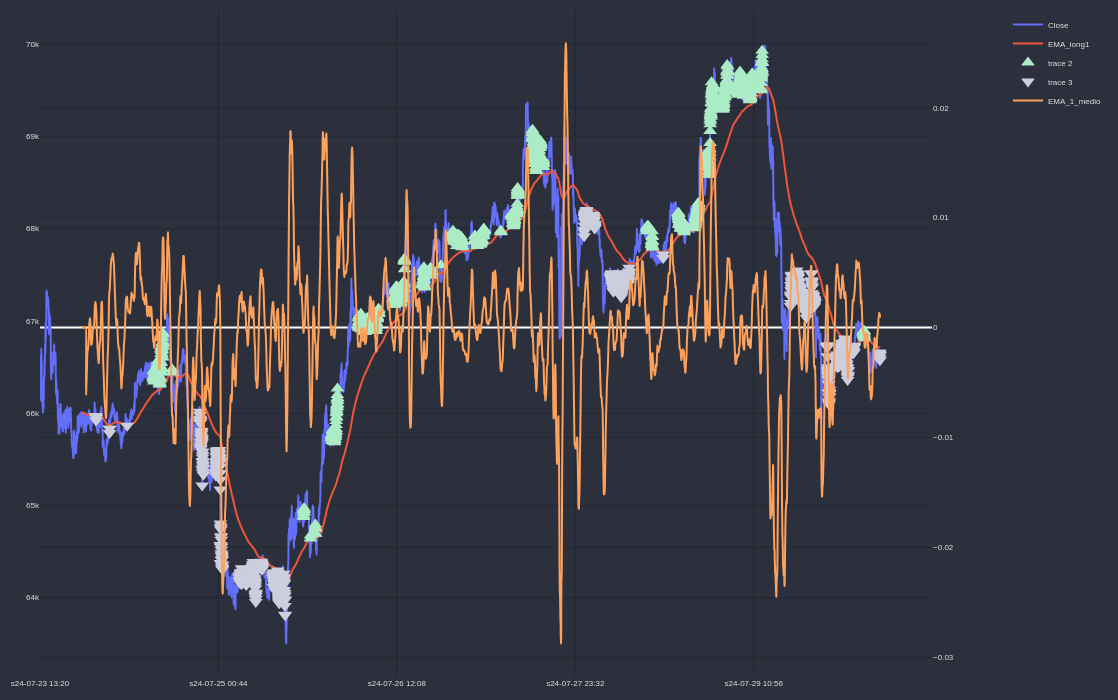

In [36]:

marker_trade_up = '#abebc6'
marker_trade_down = '#cccddd'


markers = 'Close'


cp.add_traces(['Close','EMA_long1'])


# # SIGNAL UP
cp.fig.add_trace(go.Scatter(
    x = trades_up.sTime,
    y = trades_up[markers],
    mode = 'markers',
    marker_symbol = 'triangle-up',
    marker=dict(color=marker_trade_up, size=12)
))

cp.fig.add_trace(go.Scatter(
    x = trades_down.sTime,
    y = trades_down[markers],
    mode = 'markers',
    marker_symbol = 'triangle-down',
    marker=dict(color=marker_trade_down, size=12)
))


cp.show_plot(height=700, width=1100, sec_traces=['EMA_1_medio'])

In [23]:
res = lista

# with open("./result-binance-trend-sem-limite-max_o-apenas-9.pkl", "rb") as f:
#     res = pickle.load(f)

In [24]:
res[0]['res']

In [25]:
dic_res = []
for r in res:

    if r['res'].len_close > 1:
        signal_up = r['res'].df_results.SIGNAL_UP.values[-1]
        res_pos = r['res'].df_results[r['res'].df_results['result'] > 0]
        res_neg = r['res'].df_results[r['res'].df_results['result'] < 0]
        sum_neg = res_neg.result.sum() * -1
        sum_pos = res_pos.result.sum()
        
        res_pos_s = r['res'].df_results[r['res'].df_results['strategy'] > 0]
        res_neg_s = r['res'].df_results[r['res'].df_results['strategy'] < 0]
        sum_neg_s = res_neg_s.strategy.sum() *-1
        sum_pos_s = res_pos_s.strategy.sum()
        dic_res.append(
            dict(
                pair = r['pair'],
                ema_s = r['ema_s'],
                ema_l = r['ema_l'],
                strat = round(r['res'].df_results.strategy.sum(),3),
                res = round(r['res'].df_results.result.sum(),3),
                sig = signal_up,
                c = r['res'].df_results['count'].mean(),
                wp = r['window_percent'],
                ep = r['ema_percent1'],
                max_o = max(r['res'].df_results.total_opened),

                
                s_p_s = sum_pos_s,
                s_n_s = sum_neg_s,
                Rel_sum = sum_pos_s/(sum_pos_s+ sum_neg_s),
                
                l_p_s = len(res_pos_s),
                l_n_s = len(res_neg_s),
                Rel_len = len(res_pos_s)/(len(res_pos_s)+ len(res_neg_s)),
                
                l_c = r['res'].len_close,
                l_o = r['res'].len_open,
                   
                # l_p = len(res_pos),
                # l_n = len(res_neg),
                # sum_pos = sum_pos,
                # sum_neg = sum_neg,
                # Rel_len_pos_neg = len(res_pos)/(len(res_pos)+ len(res_neg)),
                # Rel_pos_neg = sum_pos/(sum_pos+ sum_neg),

                first_p = r['res'].first_price,
                last_p = r['res'].last_price,
                r = r['res'].df_results
            )
    )
    # print(f"p={p}  e={e}  dw={dw}  dwp={dwp}   strategy={st}   result={result}")


In [26]:
df_res = pd.DataFrame(dic_res)

In [32]:
df_res

pair  ema_s  ema_l  strat      res  sig          c  wp  ep  max_o  \
0  BTCUSDT     50    500  0.468  1798.37    1  33.164602  50  50      1   

      s_p_s     s_n_s   Rel_sum  l_p_s  l_n_s   Rel_len  l_c  l_o   first_p  \
0  0.905579  0.437126  0.674444    333    232  0.589381  565    0  66510.01   

     last_p                                                  r  
0  63327.59       running  start_index_m5  count  trigger_t...

In [33]:
df_res.iloc[0].r.describe()

start_index_m5       count  trigger_type    strategy  total_opened  \
count      565.000000  565.000000    565.000000  565.000000         565.0   
mean     49344.539823   33.164602      0.001770    0.000829           1.0   
min        665.000000    2.000000     -1.000000   -0.012028           1.0   
25%      24473.000000   13.000000     -1.000000   -0.001009           1.0   
50%      49574.000000   25.000000      1.000000    0.000408           1.0   
75%      73215.000000   45.000000      1.000000    0.002091           1.0   
max      99877.000000  188.000000      1.000000    0.027235           1.0   
std      28748.897049   29.894071      1.000885    0.003714           0.0   

        start_price  trigger_price   SIGNAL_UP  SIGNAL_DOWN       result  \
count    565.000000     565.000000  565.000000   565.000000   565.000000   
mean   60883.289611   60883.055929    0.500885    -0.499115     3.182956   
min    52707.780000   52316.700000    0.000000    -1.000000  -724.600000   
25%    58375.510000   58311.190000    0.000000    -1.000000   -95.990000   
50%    60247.180000   60280.010000    1.000000     0.000000   -15.230000   
75%    63765.440000   63744.000000    1.000000     0.000000    81.100000   
max    69546.000000   69660.000000    1.000000     0.000000  1485.250000   
std     3686.660824    3690.662518    0.500442     0.500442   212.743028   

                            end_time                     start_time  
count                            565                            565  
mean   2024-08-26 20:16:42.265486848  2024-08-26 19:44:32.389380864  
min              2024-07-24 00:29:00            2024-07-24 00:25:00  
25%              2024-08-09 13:29:00            2024-08-09 13:13:00  
50%              2024-08-27 00:03:00            2024-08-26 23:34:00  
75%              2024-09-12 09:47:00            2024-09-12 09:35:00  
max              2024-09-30 22:02:00            2024-09-30 21:57:00  
std                              NaN                            NaN

In [34]:
df_res.iloc[0].r

running  start_index_m5  count  trigger_type      strategy  total_opened  \
0      False             665      5            -1 -2.453474e-05             1   
1      False             828      4            -1 -8.496266e-04             1   
2      False            1038      2            -1  3.945299e-04             1   
3      False            1350     49             1 -3.114832e-05             1   
4      False            1423     44             1  6.852718e-03             1   
5      False            1574      3             1  4.514605e-04             1   
6      False            1902     45            -1  9.027352e-03             1   
7      False            2091     83            -1  1.527398e-02             1   
8      False            2373     87            -1  5.728690e-04             1   
9      False            2506     67            -1  3.422877e-03             1   
10     False            2633     16            -1 -7.829902e-04             1   
11     False            2772     35            -1  1.650126e-03             1   
12     False            2824     34            -1  2.609411e-03             1   
13     False            2893     27            -1  3.053603e-03             1   
14     False            3137     10             1 -1.079111e-04             1   
15     False            3220      3             1 -1.394015e-03             1   
16     False            3277      7             1 -3.708638e-04             1   
17     False            3468     15             1  2.392420e-04             1   
18     False            3501     45             1  5.128481e-03             1   
19     False            3790    114             1  1.492243e-04             1   
20     False            3992     43             1  9.349805e-04             1   
21     False            4204     47             1  1.259827e-03             1   
22     False            4288     20             1  1.096746e-03             1   
23     False            4317     25             1  2.613122e-03             1   
24     False            4555     25             1 -5.201843e-04             1   
25     False            4643     11             1  8.000770e-04             1   
26     False            4774      2             1 -1.214324e-03             1   
27     False            4909    121             1 -1.886698e-03             1   
28     False            5175      6             1  4.462821e-04             1   
29     False            5205     21             1  5.913051e-04             1   
30     False            5242     50             1  2.031750e-03             1   
31     False            5485      4             1 -2.461277e-04             1   
32     False            5613     84             1  3.017342e-03             1   
33     False            5859    106             1 -1.682490e-03             1   
34     False            5985     11             1 -2.000655e-03             1   
35     False            6478     29            -1 -3.564265e-03             1   
36     False            6566     42            -1  4.403354e-04             1   
37     False            6793     42            -1  2.073875e-03             1   
38     False            6882     49            -1  2.134457e-03             1   
39     False            6989     27            -1 -2.129845e-03             1   
40     False            7225     22             1  1.945050e-04             1   
41     False            7280     14             1 -3.994440e-04             1   
42     False            7419      3            -1 -8.154255e-04             1   
43     False            7596     73             1 -3.761050e-03             1   
44     False            7786     56             1  2.905959e-03             1   
45     False            7927     17             1  2.184036e-03             1   
46     False            7962     52             1  1.363598e-02             1   
47     False            8103     86             1  5.111481e-03             1   
48     False            8279     66 

In [30]:
df_sorted_desc = df_res.sort_values(by=['pair','strat'], ascending=False)

In [31]:
# Exibir todas as linhas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df_sorted_desc.head()

pair  ema_s  ema_l  strat      res  sig          c  wp  ep  max_o  \
0  BTCUSDT     50    500  0.468  1798.37    1  33.164602  50  50      1   

      s_p_s     s_n_s   Rel_sum  l_p_s  l_n_s   Rel_len  l_c  l_o   first_p  \
0  0.905579  0.437126  0.674444    333    232  0.589381  565    0  66510.01   

     last_p                                                  r  
0  63327.59       running  start_index_m5  count  trigger_t...

In [18]:
def rank_backtest_results(df):
    # Definindo pesos para cada coluna com base na importância
    weights = {
        'strat': 0.4,           # Retorno acumulado percentual (maximizar)
        'Rel_len': 0.1,      # Relação de trades positivos/negativos (maximizar)
        'Rel_sum': 0.1,        # Relação de resultados positivos/negativos (maximizar)
        'l_p_s': 0.1,            # Quantidade de trades positivos (maximizar)
        'l_n_s': -0.1,           # Quantidade de trades negativos (minimizar)
        's_p_s': 0.05,           # Soma dos retornos positivos (maximizar)
        's_n_s': -0.05,          # Soma dos retornos negativos (minimizar)
        'c': -0.05,          # Média de candles até TP ou SL (minimizar)
        'max_o': -0.1,       # Máximo de operações abertas ao mesmo tempo (minimizar)
        # 'ema': -0.01,            # EMA short (minimizar)
        # 'tp': 0.1,             # Take profit percentual (minimizar)
        # 'sl': -0.05,             # Stop loss percentual (minimizar)
        # 'dw': -0.01              # Janela Donchian (minimizar)
    }
    
    # Normalizando as colunas relevantes
    for col in weights.keys():
        df[col + '_norm'] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
    
    # Calculando o score ponderado para cada linha
    df['score'] = sum(
        df[col + '_norm'] * weight if weight >= 0 else (1 - df[col + '_norm']) * abs(weight) 
        for col, weight in weights.items()
    )
    
    # Ordenando o DataFrame pelos melhores resultados com base no score
    df_sorted = df.sort_values(by='score', ascending=False).reset_index(drop=True)
    
    # Removendo colunas de normalização temporárias
    df_sorted.drop(columns=[col + '_norm' for col in weights.keys()], inplace=True)
    
    return df_sorted

In [19]:
df_ADAUSDT = df_res[df_res['pair']=='ADAUSDT']
df_BTCUSDT = df_res[df_res['pair']=='BTCUSDT']
df_ETHUSDT = df_res[df_res['pair']=='ETHUSDT']
df_BNBUSDT = df_res[df_res['pair']=='BNBUSDT']
df_XRPUSDT = df_res[df_res['pair']=='XRPUSDT']
df_LTCUSDT = df_res[df_res['pair']=='LTCUSDT']

In [20]:
df_ADAUSDT.columns

Index(['pair', 'ema', 'strat', 'res', 'sig', 'c', 'tp', 'sl', 'dw', 'dwp',
       'max_o', 's_p_s', 's_n_s', 'Rel_sum', 'l_p_s', 'l_n_s', 'Rel_len',
       'l_c', 'l_o', 'first_p', 'last_p', 'r'],
      dtype='object')

In [21]:
rank_ADAUSDT = rank_backtest_results(df_ADAUSDT)
rank_BTCUSDT = rank_backtest_results(df_BTCUSDT)
rank_ETHUSDT = rank_backtest_results(df_ETHUSDT)
rank_BNBUSDT = rank_backtest_results(df_BNBUSDT)
rank_XRPUSDT = rank_backtest_results(df_XRPUSDT)
rank_LTCUSDT = rank_backtest_results(df_LTCUSDT)

In [22]:
rank_ADAUSDT[['pair', 'ema', 'strat', 'res', 'sig', 'c', 'tp', 'sl', 'dw', 'dwp',
       'max_o', 's_p_s', 's_n_s', 'Rel_sum', 'l_p_s', 'l_n_s']].head(10)

pair  ema  strat    res  sig            c  tp  sl   dw  dwp  max_o  \
0  ADAUSDT    1  0.493  0.291    0   993.276596   1   1  500    5     11   
1  ADAUSDT    1  0.623  0.334    0  1103.125000   1   3  500    5     11   
2  ADAUSDT    1  1.053  0.473    1  1937.604167   1   5  500    5     11   
3  ADAUSDT    1  1.803  0.727    1  2490.425000   1   7  500    5     11   
4  ADAUSDT    1  2.128  0.751    1  2820.432292   1  10  500    5     11   
5  ADAUSDT    1  0.227  0.133    0  3054.545455   2   1  500    5     11   
6  ADAUSDT    1  0.445  0.224    1  4790.090909   2   3  500    5     11   
7  ADAUSDT    1  1.303  0.550    0  4722.737705   2   5  500    5     11   
8  ADAUSDT    1  2.417  0.941    1  4469.681416   2   7  500    5     11   
9  ADAUSDT    1  2.211  0.797    1  5362.952381   2  10  500    5     11   

      s_p_s  s_n_s  Rel_sum  l_p_s  l_n_s  
0  0.493400   -0.0      1.0     47      0  
1  0.623258   -0.0      1.0     56      0  
2  1.053353   -0.0      1.0     96      0  
3  1.802752   -0.0      1.0    160      0  
4  2.127718   -0.0      1.0    192      0  
5  0.227343   -0.0      1.0     11      0  
6  0.444714   -0.0      1.0     22      0  
7  1.302647   -0.0      1.0     61      0  
8  2.416868   -0.0      1.0    113      0  
9  2.210983   -0.0      1.0    105      0

In [24]:
rank_BTCUSDT[['pair', 'ema', 'strat', 'res', 'sig', 'c', 'tp', 'sl', 'dw', 'dwp',
       'max_o', 's_p_s', 's_n_s', 'Rel_sum', 'l_p_s', 'l_n_s']].head(10)

pair  ema  strat        res  sig             c  tp  sl   dw  dwp  max_o  \
0  BTCUSDT    1  1.744   91555.87    0   9567.546584   1   1  500    5     11   
1  BTCUSDT    1  3.329  182508.27    1   4924.233333   1   3  500    5     11   
2  BTCUSDT    1  2.235  119931.02    1   5014.802956   1   5  500    5     11   
3  BTCUSDT    1  1.817   99707.38    1   4319.668675   1   7  500    5      8   
4  BTCUSDT    1  1.100   59323.55    1   4677.715686   1  10  500    5      7   
5  BTCUSDT    1  1.600   83858.69    0  18856.792208   2   1  500    5     11   
6  BTCUSDT    1  2.813  154646.57    1  10227.925373   2   3  500    5     11   
7  BTCUSDT    1  1.779   98535.25    1   7395.576471   2   7  500    5     10   
8  BTCUSDT    1  2.392  132239.31    1   8421.438596   2   5  500    5     11   
9  BTCUSDT    1  1.176   64911.80    1   7134.589286   2  10  500    5      6   

      s_p_s  s_n_s  Rel_sum  l_p_s  l_n_s  
0  1.743897   -0.0      1.0    161      0  
1  3.329271   -0.0      1.0    300      0  
2  2.234541   -0.0      1.0    203      0  
3  1.817489   -0.0      1.0    166      0  
4  1.099848   -0.0      1.0    102      0  
5  1.599682   -0.0      1.0     77      0  
6  2.813004   -0.0      1.0    134      0  
7  1.778921   -0.0      1.0     85      0  
8  2.391502   -0.0      1.0    114      0  
9  1.176094   -0.0      1.0     56      0

In [25]:
rank_ETHUSDT[['pair', 'ema', 'strat', 'res', 'sig', 'c', 'tp', 'sl', 'dw', 'dwp',
       'max_o', 's_p_s', 's_n_s', 'Rel_sum', 'l_p_s', 'l_n_s']].head(10)

pair  ema  strat      res  sig             c  tp  sl    dw  dwp  max_o  \
0  ETHUSDT    1  2.461  7413.28    1   2512.578199   1   1  4000    5     11   
1  ETHUSDT    1  2.566  7711.30    0   4730.789916   2   1  4000    5     11   
2  ETHUSDT    1  2.380  7149.98    0   3309.402010   1   3  1500    5     11   
3  ETHUSDT    1  2.642  7959.08    0  11694.459016   4   3  1500    5     11   
4  ETHUSDT    1  2.364  7090.30    0   3730.183673   1   3   500    5     11   
5  ETHUSDT    1  2.553  7635.96    0  11887.500000   4   3  1000    5     11   
6  ETHUSDT    1  2.271  6770.93    0   3691.037634   1   1  1500    5     11   
7  ETHUSDT    1  2.246  6646.72    0   4037.961957   1   3  1000    5     11   
8  ETHUSDT    1  2.189  6459.32    0   3738.775281   1   1  2500    5     11   
9  ETHUSDT    1  2.439  6595.69    0  10381.304348   5   7  2500    5     11   

      s_p_s  s_n_s  Rel_sum  l_p_s  l_n_s  
0  2.461225   -0.0      1.0    211      0  
1  2.566106   -0.0      1.0    119      0  
2  2.379740   -0.0      1.0    199      0  
3  2.641755   -0.0      1.0     61      0  
4  2.364477   -0.0      1.0    196      0  
5  2.552652   -0.0      1.0     60      0  
6  2.270532   -0.0      1.0    186      0  
7  2.245808   -0.0      1.0    184      0  
8  2.188838   -0.0      1.0    178      0  
9  2.438694   -0.0      1.0     46      0

In [26]:
rank_BNBUSDT[['pair', 'ema', 'strat', 'res', 'sig', 'c', 'tp', 'sl', 'dw', 'dwp',
       'max_o', 's_p_s', 's_n_s', 'Rel_sum', 'l_p_s', 'l_n_s']].head(10)

pair  ema  strat     res  sig             c  tp  sl   dw  dwp  max_o  \
0  BNBUSDT    1  2.445  1197.8    1   5469.882353   1   3  500    5     11   
1  BNBUSDT    1  2.420  1303.9    0   3788.540909   1   1  500    5     11   
2  BNBUSDT    1  2.691  1307.6    1   4174.863636   1   5  500    5     11   
3  BNBUSDT    1  1.873   935.3    1   2683.664634   1  10  500    5      8   
4  BNBUSDT    1  2.260  1094.9    0   3616.451777   1   7  500    5     11   
5  BNBUSDT    1  2.626  1265.0    1  10606.544000   2   3  500    5     11   
6  BNBUSDT    1  2.564  1384.4    1   6882.272727   2   1  500    5     11   
7  BNBUSDT    1  2.724  1320.6    1   7682.393701   2   5  500    5     11   
8  BNBUSDT    1  2.377  1142.3    1   7270.990909   2   7  500    5     11   
9  BNBUSDT    1  1.879   938.0    1   5493.340909   2  10  500    5      7   

      s_p_s  s_n_s  Rel_sum  l_p_s  l_n_s  
0  2.444885   -0.0      1.0    221      0  
1  2.419735   -0.0      1.0    220      0  
2  2.691149   -0.0      1.0    242      0  
3  1.873045   -0.0      1.0    164      0  
4  2.259718   -0.0      1.0    197      0  
5  2.626151   -0.0      1.0    125      0  
6  2.564152   -0.0      1.0    121      0  
7  2.724246   -0.0      1.0    127      0  
8  2.376935   -0.0      1.0    110      0  
9  1.878674   -0.0      1.0     88      0

In [27]:
rank_XRPUSDT[['pair', 'ema', 'strat', 'res', 'sig', 'c', 'tp', 'sl', 'dw', 'dwp',
       'max_o', 's_p_s', 's_n_s', 'Rel_sum', 'l_p_s', 'l_n_s']].head(10)

pair  ema  strat    res  sig             c  tp  sl    dw  dwp  max_o  \
0  XRPUSDT    1  5.782  2.725    0  32587.000000  10   3  1500    5     11   
1  XRPUSDT    1  5.627  2.569    1  28118.285714   7   3   500    5     11   
2  XRPUSDT    1  5.367  2.474    1  17361.480392   5   3  1500    5     11   
3  XRPUSDT    1  5.116  2.340    1  17811.275510   5   3  2500    5     11   
4  XRPUSDT    1  5.234  2.387    1  39640.941176  10   3  2500    5     11   
5  XRPUSDT    1  4.922  2.227    1  15805.846154   4   3  1500    5     11   
6  XRPUSDT    1  4.298  1.825    0   7185.676056   1   1   500    5     11   
7  XRPUSDT    1  4.599  2.027    0   5811.615591   1   3   500    5     11   
8  XRPUSDT    1  4.636  2.025    0  12421.383495   2   1   500    5     11   
9  XRPUSDT    1  4.541  1.982    1  12743.041026   2   1  1000    5     11   

      s_p_s     s_n_s   Rel_sum  l_p_s  l_n_s  
0  5.782040 -0.000000  1.000000     57      0  
1  5.626825 -0.000000  1.000000     77      0  
2  5.367227 -0.000000  1.000000    102      0  
3  5.116013 -0.000000  1.000000     98      0  
4  5.233719 -0.000000  1.000000     51      0  
5  4.921849 -0.000000  1.000000    117      0  
6  4.298227 -0.000000  1.000000    355      0  
7  4.599278  0.000249  0.999946    371      1  
8  4.635603 -0.000000  1.000000    206      0  
9  4.541061 -0.000000  1.000000    195      0

In [28]:
rank_LTCUSDT[['pair', 'ema', 'strat', 'res', 'sig', 'c', 'tp', 'sl', 'dw', 'dwp',
       'max_o', 's_p_s', 's_n_s', 'Rel_sum', 'l_p_s', 'l_n_s']].head(10)

pair  ema  strat     res  sig             c  tp  sl    dw  dwp  max_o  \
0  LTCUSDT    1  2.149  145.56    1  10674.038462   4   7  1500    5     11   
1  LTCUSDT    1  1.982  148.30    0   4110.589474   2   7  1500    5     11   
2  LTCUSDT    1  1.679  113.73    1   3004.322581   1  10  2500    5     11   
3  LTCUSDT    1  1.809  133.62    0   4267.586207   2   7   500    5     11   
4  LTCUSDT    1  1.869  130.55    1   7034.655738   3   7  1500    5     11   
5  LTCUSDT    1  1.779  130.81    0   4296.011628   2   7  1000    5     11   
6  LTCUSDT    1  1.612  121.95    1   2598.266667   1   7   500    5     11   
7  LTCUSDT    1  1.599  120.78    1   2628.831081   1   7  1000    5     11   
8  LTCUSDT    1  1.870  140.09    0  11211.217391   4   5   500    5     11   
9  LTCUSDT    1  1.711  141.24    1   2549.329268   2   5  1500    5     11   

      s_p_s  s_n_s  Rel_sum  l_p_s  l_n_s  
0  2.148719   -0.0      1.0     52      0  
1  1.981586   -0.0      1.0     95      0  
2  1.679011   -0.0      1.0    155      0  
3  1.809412   -0.0      1.0     87      0  
4  1.869046   -0.0      1.0     61      0  
5  1.779306   -0.0      1.0     86      0  
6  1.611619   -0.0      1.0    150      0  
7  1.599126   -0.0      1.0    148      0  
8  1.870305   -0.0      1.0     46      0  
9  1.711450   -0.0      1.0     82      0

In [29]:
def rank_tests(df, total_investment):
    # Calcula o capital fracionado para cada teste com base em max_o
    df['capital_fracionado'] = total_investment / df['max_o']
    
    # Calcula o retorno total ajustado, considerando o capital fracionado e o retorno percentual (strat)
    df['retorno_ajustado'] = df['capital_fracionado'] * df['strat']
    
    # Ordena o DataFrame pelo retorno ajustado em ordem decrescente
    ranked_df = df.sort_values(by='retorno_ajustado', ascending=False).reset_index(drop=True)
    
    return ranked_df

In [30]:
total_investment = 5000
rank_ADAUSDT_inv = rank_tests(rank_ADAUSDT, total_investment)
rank_ADAUSDT_inv[['pair', 'ema', 'strat', 'res', 'sig', 'c', 'tp', 'sl', 'dw', 'dwp',
       'max_o', 's_p_s', 's_n_s', 'Rel_sum', 'l_p_s', 'l_n_s','capital_fracionado','retorno_ajustado']].head(10)

pair  ema  strat    res  sig             c  tp  sl    dw  dwp  max_o  \
0  ADAUSDT    1  3.111  1.118    1  10156.049180   5   7  1500    5     11   
1  ADAUSDT    1  2.902  1.085    1   6697.295775   4  10  1500    5     11   
2  ADAUSDT    1  2.901  1.084    1   6695.549296   4  10  1000    5     11   
3  ADAUSDT    1  2.901  1.084    1   6697.140845   4  10   500    5     11   
4  ADAUSDT    1  2.700  0.981    1  11236.452830   5   7  2500    5     11   
5  ADAUSDT    1  2.659  0.962    1  11019.250000   5  10  2500    5     11   
6  ADAUSDT    1  2.607  0.956    1   7305.984375   4  10  2500    5     11   
7  ADAUSDT    1  2.557  0.952    1   6356.891566   3  10  4000    5     11   
8  ADAUSDT    1  2.554  0.910    1  11407.480000   5  10   500    5     11   
9  ADAUSDT    1  2.553  0.910    1  11418.500000   5  10  4000    5     11   

      s_p_s  s_n_s  Rel_sum  l_p_s  l_n_s  capital_fracionado  \
0  3.111169   -0.0      1.0     61      0          454.545455   
1  2.902256   -0.0      1.0     71      0          454.545455   
2  2.900525   -0.0      1.0     71      0          454.545455   
3  2.900860   -0.0      1.0     71      0          454.545455   
4  2.699756   -0.0      1.0     53      0          454.545455   
5  2.659031   -0.0      1.0     52      0          454.545455   
6  2.607342   -0.0      1.0     64      0          454.545455   
7  2.556717   -0.0      1.0     83      0          454.545455   
8  2.553854   -0.0      1.0     50      0          454.545455   
9  2.553077   -0.0      1.0     50      0          454.545455   

   retorno_ajustado  
0       1414.090909  
1       1319.090909  
2       1318.636364  
3       1318.636364  
4       1227.272727  
5       1208.636364  
6       1185.000000  
7       1162.272727  
8       1160.909091  
9       1160.454545

In [31]:
total_investment = 5000
rank_BTCUSDT_inv = rank_tests(rank_BTCUSDT, total_investment)
rank_BTCUSDT_inv[['pair', 'ema', 'strat', 'res', 'sig', 'c', 'tp', 'sl', 'dw', 'dwp',
       'max_o', 's_p_s', 's_n_s', 'Rel_sum', 'l_p_s', 'l_n_s','capital_fracionado','retorno_ajustado']].head(10)

pair  ema  strat        res  sig             c  tp  sl    dw  dwp  \
0  BTCUSDT    1  3.329  182508.27    1   4924.233333   1   3   500    5   
1  BTCUSDT    1  3.070  166486.25    1   5210.128571   1   3  1000    5   
2  BTCUSDT    1  3.020  164292.83    1   5280.156934   1   3  1500    5   
3  BTCUSDT    1  2.864  157197.85    1   4720.003861   1   3  2500    5   
4  BTCUSDT    1  2.306  131437.03    1  24881.260870  10   5  2500    5   
5  BTCUSDT    1  2.813  154646.57    1  10227.925373   2   3   500    5   
6  BTCUSDT    1  2.024  111443.37    1   7623.432990   2   7  4000    5   
7  BTCUSDT    1  2.723  149483.03    0  13721.318182   3   3  1000    5   
8  BTCUSDT    1  2.700  146654.99    0   6266.939516   1   1  4000    5   
9  BTCUSDT    1  2.649  144880.12    1   4703.116183   1   3  4000    5   

   max_o     s_p_s  s_n_s  Rel_sum  l_p_s  l_n_s  capital_fracionado  \
0     11  3.329271   -0.0      1.0    300      0          454.545455   
1     11  3.069730   -0.0      1.0    280      0          454.545455   
2     11  3.020024   -0.0      1.0    274      0          454.545455   
3     11  2.863983   -0.0      1.0    259      0          454.545455   
4      9  2.305959   -0.0      1.0     23      0          555.555556   
5     11  2.813004   -0.0      1.0    134      0          454.545455   
6      8  2.024123   -0.0      1.0     97      0          625.000000   
7     11  2.722647   -0.0      1.0     88      0          454.545455   
8     11  2.699518   -0.0      1.0    248      0          454.545455   
9     11  2.648942   -0.0      1.0    241      0          454.545455   

   retorno_ajustado  
0       1513.181818  
1       1395.454545  
2       1372.727273  
3       1301.818182  
4       1281.111111  
5       1278.636364  
6       1265.000000  
7       1237.727273  
8       1227.272727  
9       1204.090909

In [32]:
total_investment = 5000
rank_ETHUSDT_inv = rank_tests(rank_ETHUSDT, total_investment)
rank_ETHUSDT_inv[['pair', 'ema', 'strat', 'res', 'sig', 'c', 'tp', 'sl', 'dw', 'dwp',
       'max_o', 's_p_s', 's_n_s', 'Rel_sum', 'l_p_s', 'l_n_s','capital_fracionado','retorno_ajustado']].head(10)

pair  ema  strat      res  sig             c  tp  sl    dw  dwp  max_o  \
0  ETHUSDT    1  2.642  7959.08    0  11694.459016   4   3  1500    5     11   
1  ETHUSDT    1  2.566  7711.30    0   4730.789916   2   1  4000    5     11   
2  ETHUSDT    1  2.553  7635.96    0  11887.500000   4   3  1000    5     11   
3  ETHUSDT    1  2.461  7413.28    1   2512.578199   1   1  4000    5     11   
4  ETHUSDT    1  2.439  6595.69    0  10381.304348   5   7  2500    5     11   
5  ETHUSDT    1  2.431  6567.83    0  10385.543478   5   7  1500    5     11   
6  ETHUSDT    1  2.413  7105.50    0  29070.869565  10   3  1500    5     11   
7  ETHUSDT    1  2.389  6320.75    1   9716.666667   4   7   500    5     11   
8  ETHUSDT    1  2.388  6317.35    1   9716.526316   4   7  1000    5     11   
9  ETHUSDT    1  2.380  7149.98    0   3309.402010   1   3  1500    5     11   

      s_p_s  s_n_s  Rel_sum  l_p_s  l_n_s  capital_fracionado  \
0  2.641755   -0.0      1.0     61      0          454.545455   
1  2.566106   -0.0      1.0    119      0          454.545455   
2  2.552652   -0.0      1.0     60      0          454.545455   
3  2.461225   -0.0      1.0    211      0          454.545455   
4  2.438694   -0.0      1.0     46      0          454.545455   
5  2.430733   -0.0      1.0     46      0          454.545455   
6  2.413149   -0.0      1.0     23      0          454.545455   
7  2.389385   -0.0      1.0     57      0          454.545455   
8  2.388452   -0.0      1.0     57      0          454.545455   
9  2.379740   -0.0      1.0    199      0          454.545455   

   retorno_ajustado  
0       1200.909091  
1       1166.363636  
2       1160.454545  
3       1118.636364  
4       1108.636364  
5       1105.000000  
6       1096.818182  
7       1085.909091  
8       1085.454545  
9       1081.818182

In [33]:
total_investment = 5000
rank_BNBUSDT_inv = rank_tests(rank_BNBUSDT, total_investment)
rank_BNBUSDT_inv[['pair', 'ema', 'strat', 'res', 'sig', 'c', 'tp', 'sl', 'dw', 'dwp',
       'max_o', 's_p_s', 's_n_s', 'Rel_sum', 'l_p_s', 'l_n_s','capital_fracionado','retorno_ajustado']].head(10)

pair  ema  strat     res  sig             c  tp  sl    dw  dwp  max_o  \
0  BNBUSDT    1  3.736  1854.8    0  31235.783784  10   5   500    5     11   
1  BNBUSDT    1  3.435  1727.5    1  26699.294118  10   5  1500    5     11   
2  BNBUSDT    1  3.338  1690.0    1  27419.303030  10   5  4000    5     11   
3  BNBUSDT    1  3.337  1683.4    1  24759.606061  10   5  1000    5     11   
4  BNBUSDT    1  3.236  1627.5    1  20561.630435   7   5   500    5     11   
5  BNBUSDT    1  2.619  1292.1    1  29243.769231  10   7  1000    5      9   
6  BNBUSDT    1  2.616  1291.9    1  28396.730769  10   7  1500    5      9   
7  BNBUSDT    1  3.194  1591.9    1  18201.955556   7   5  2500    5     11   
8  BNBUSDT    1  3.145  1583.3    1  28365.129032  10   5  2500    5     11   
9  BNBUSDT    1  3.128  1612.1    0  38033.516129  10   3  1000    5     11   

      s_p_s  s_n_s  Rel_sum  l_p_s  l_n_s  capital_fracionado  \
0  3.735663   -0.0      1.0     37      0          454.545455   
1  3.435018   -0.0      1.0     34      0          454.545455   
2  3.337712   -0.0      1.0     33      0          454.545455   
3  3.337382   -0.0      1.0     33      0          454.545455   
4  3.236152   -0.0      1.0     46      0          454.545455   
5  2.619302   -0.0      1.0     26      0          555.555556   
6  2.615876   -0.0      1.0     26      0          555.555556   
7  3.193970   -0.0      1.0     45      0          454.545455   
8  3.145026   -0.0      1.0     31      0          454.545455   
9  3.128153   -0.0      1.0     31      0          454.545455   

   retorno_ajustado  
0       1698.181818  
1       1561.363636  
2       1517.272727  
3       1516.818182  
4       1470.909091  
5       1455.000000  
6       1453.333333  
7       1451.818182  
8       1429.545455  
9       1421.818182

In [34]:
total_investment = 5000
rank_XRPUSDT_inv = rank_tests(rank_XRPUSDT, total_investment)
rank_XRPUSDT_inv[['pair', 'ema', 'strat', 'res', 'sig', 'c', 'tp', 'sl', 'dw', 'dwp',
       'max_o', 's_p_s', 's_n_s', 'Rel_sum', 'l_p_s', 'l_n_s','capital_fracionado','retorno_ajustado']].head(10)

pair  ema  strat    res  sig             c  tp  sl    dw  dwp  max_o  \
0  XRPUSDT    1  5.782  2.725    0  32587.000000  10   3  1500    5     11   
1  XRPUSDT    1  5.627  2.569    1  28118.285714   7   3   500    5     11   
2  XRPUSDT    1  5.367  2.474    1  17361.480392   5   3  1500    5     11   
3  XRPUSDT    1  5.234  2.387    1  39640.941176  10   3  2500    5     11   
4  XRPUSDT    1  5.116  2.340    1  17811.275510   5   3  2500    5     11   
5  XRPUSDT    1  5.018  2.295    0  49077.142857  10   1  2500    5     11   
6  XRPUSDT    1  4.922  2.227    1  15805.846154   4   3  1500    5     11   
7  XRPUSDT    1  4.780  2.092    1  32977.138462   7   3  1000    5     11   
8  XRPUSDT    1  4.726  2.098    1  28038.533333   5   1  1500    5     11   
9  XRPUSDT    1  4.709  2.114    1  17721.160377   4   1  4000    5     11   

      s_p_s  s_n_s  Rel_sum  l_p_s  l_n_s  capital_fracionado  \
0  5.782040   -0.0      1.0     57      0          454.545455   
1  5.626825   -0.0      1.0     77      0          454.545455   
2  5.367227   -0.0      1.0    102      0          454.545455   
3  5.233719   -0.0      1.0     51      0          454.545455   
4  5.116013   -0.0      1.0     98      0          454.545455   
5  5.018005   -0.0      1.0     49      0          454.545455   
6  4.921849   -0.0      1.0    117      0          454.545455   
7  4.779890   -0.0      1.0     65      0          454.545455   
8  4.725903   -0.0      1.0     90      0          454.545455   
9  4.709453   -0.0      1.0    106      0          454.545455   

   retorno_ajustado  
0       2628.181818  
1       2557.727273  
2       2439.545455  
3       2379.090909  
4       2325.454545  
5       2280.909091  
6       2237.272727  
7       2172.727273  
8       2148.181818  
9       2140.454545

In [35]:
total_investment = 5000
rank_LTCUSDT_inv = rank_tests(rank_LTCUSDT, total_investment)
rank_LTCUSDT_inv[['pair', 'ema', 'strat', 'res', 'sig', 'c', 'tp', 'sl', 'dw', 'dwp',
       'max_o', 's_p_s', 's_n_s', 'Rel_sum', 'l_p_s', 'l_n_s','capital_fracionado','retorno_ajustado']].head(10)

pair  ema  strat     res  sig             c  tp  sl    dw  dwp  max_o  \
0  LTCUSDT    1  2.149  145.56    1  10674.038462   4   7  1500    5     11   
1  LTCUSDT    1  1.982  148.30    0   4110.589474   2   7  1500    5     11   
2  LTCUSDT    1  1.920  140.80    1   2648.827778   1   7  1500    5     11   
3  LTCUSDT    1  1.870  140.09    0  11211.217391   4   5   500    5     11   
4  LTCUSDT    1  1.869  130.55    1   7034.655738   3   7  1500    5     11   
5  LTCUSDT    1  1.809  133.62    0   4267.586207   2   7   500    5     11   
6  LTCUSDT    1  1.790  120.76    1  11141.340909   4  10   500    5     11   
7  LTCUSDT    1  1.779  130.81    0   4296.011628   2   7  1000    5     11   
8  LTCUSDT    1  1.777  119.46    1  11142.454545   4  10  1500    5     11   
9  LTCUSDT    1  1.777  119.46    1  11142.454545   4  10  1000    5     11   

      s_p_s    s_n_s   Rel_sum  l_p_s  l_n_s  capital_fracionado  \
0  2.148719 -0.00000  1.000000     52      0          454.545455   
1  1.981586 -0.00000  1.000000     95      0          454.545455   
2  1.926713  0.00654  0.996617    179      1          454.545455   
3  1.870305 -0.00000  1.000000     46      0          454.545455   
4  1.869046 -0.00000  1.000000     61      0          454.545455   
5  1.809412 -0.00000  1.000000     87      0          454.545455   
6  1.789939 -0.00000  1.000000     44      0          454.545455   
7  1.779306 -0.00000  1.000000     86      0          454.545455   
8  1.776689 -0.00000  1.000000     44      0          454.545455   
9  1.776689 -0.00000  1.000000     44      0          454.545455   

   retorno_ajustado  
0        976.818182  
1        900.909091  
2        872.727273  
3        850.000000  
4        849.545455  
5        822.272727  
6        813.636364  
7        808.636364  
8        807.727273  
9        807.727273

In [36]:
rank_LTCUSDT_inv.columns

Index(['pair', 'ema', 'strat', 'res', 'sig', 'c', 'tp', 'sl', 'dw', 'dwp',
       'max_o', 's_p_s', 's_n_s', 'Rel_sum', 'l_p_s', 'l_n_s', 'Rel_len',
       'l_c', 'l_o', 'first_p', 'last_p', 'r', 'score', 'capital_fracionado',
       'retorno_ajustado'],
      dtype='object')

In [37]:
# df_results = res[108]['res'].df_results
# pair = res[108]['pair']
# print(pair)
# print(df_results.columns)
# res_pos = df_results[df_results['strategy'] > 0]
# res_neg = df_results[df_results['strategy'] < 0]
# df_results.shape, res_pos.shape, res_neg.shape

In [38]:
def calcular_operacoes_simultaneas(df):
    # Ordena o DataFrame por start_time para facilitar o cálculo
    df = df.sort_values(by='start_time').reset_index(drop=True)
    # Inicializa a coluna operacoes_simultaneas com o valor mínimo de 1
    df['operacoes_simultaneas'] = 1
    
    # Itera sobre cada operação e conta quantas estão abertas e não fechadas no momento
    for i, row in df.iterrows():
        # Conta quantas operações estão em andamento no tempo de start_time da operação atual
        count = ((df['start_time'] <= row['start_time']) & (df['end_time'] > row['start_time'])).sum()
        # Atualiza a coluna com o número de operações simultâneas, garantindo o mínimo de 1
        df.at[i, 'operacoes_simultaneas'] = max(count, 1)
        
    return df

In [39]:
concat_ranks = pd.concat([rank_ADAUSDT_inv.iloc[0].r,
                          rank_BTCUSDT_inv.iloc[0].r, 
                          rank_ETHUSDT_inv.iloc[0].r, 
                          rank_BNBUSDT_inv.iloc[0].r, 
                          rank_XRPUSDT_inv.iloc[0].r, 
                          rank_LTCUSDT_inv.iloc[0].r])

df_test = calcular_operacoes_simultaneas(concat_ranks)
df_test.operacoes_simultaneas.max()

np.int64(45)

In [43]:
concat_ranks.columns

Index(['running', 'start_index_m5', 'count', 'trigger_type', 'strategy',
       'total_opened', 'threshold_up', 'threshold_down', 'start_price',
       'trigger_price', 'SIGNAL_UP', 'SIGNAL_DOWN', 'result', 'end_time',
       'start_time'],
      dtype='object')

In [44]:
df_test.strategy.sum()

np.float64(20.748616442547785)

In [56]:
(10000/df_test.operacoes_simultaneas.max()) * df_test.strategy.sum()

np.float64(4610.803653899508)

In [57]:
df_test.tail()

running  start_index_m5  count  trigger_type  strategy  total_opened  \
563    False          258171   4990             1  0.010785             4   
564    False          259226    839             1  0.053424            10   
565    False          260064   3022             1  0.051077             8   
566    False          263161    167             1  0.010876             5   
567    False          263327   1290             1  0.010055             4   

     threshold_up  threshold_down  start_price  trigger_price  SIGNAL_UP  \
563             1               3   64346.8800     64999.9900          1   
564             5               7       0.3734         0.3937          1   
565             5               7       0.3937         0.4139          1   
566             1               3   64999.9900     65706.0000          1   
567             1               3   65754.0100     66408.0100          1   

     SIGNAL_DOWN    result            end_time          start_time  \
563            0  653.1100 2024-09-26 14:20:00 2024-09-23 03:10:00   
564            0    0.0203 2024-09-25 03:24:00 2024-09-24 13:25:00   
565            0    0.0202 2024-09-27 05:45:00 2024-09-25 03:23:00   
566            0  706.0100 2024-09-26 17:07:00 2024-09-26 14:20:00   
567            0  654.0000 2024-09-27 14:36:00 2024-09-26 17:06:00   

     operacoes_simultaneas  
563                     23  
564                     14  
565                     14  
566                     11  
567                     12

In [47]:
rank_ADAUSDT.iloc[0].r.tail()

running  start_index_m5  count  trigger_type  strategy  total_opened  \
42    False            7146  11118             1  0.010218             9   
43    False           18411     36             0  0.012386            10   
44    False           19018   1792             0  0.011568            11   
45    False           21081     96             0  0.008931            11   
46    False           21208    391             0  0.009443            11   

    threshold_up  threshold_down  start_price  trigger_price  SIGNAL_UP  \
42             1               1       0.6183         0.6217          1   
43             1               1       0.5945         0.6019          0   
44             1               1       0.5861         0.5924          0   
45             1               1       0.5829         0.5881          0   
46             1               1       0.5784         0.5838          0   

    SIGNAL_DOWN  result            end_time          start_time  
42            0  0.0034 2024-04-09 12:43:00 2024-04-01 19:25:00  
43            1  0.0074 2024-04-09 15:46:00 2024-04-09 15:10:00  
44            1  0.0063 2024-04-11 07:09:00 2024-04-10 01:17:00  
45            1  0.0052 2024-04-11 13:16:00 2024-04-11 11:40:00  
46            1  0.0054 2024-04-11 20:18:00 2024-04-11 13:47:00

ADAUSDT 0.6474 0.3733 -0.7342619876774711


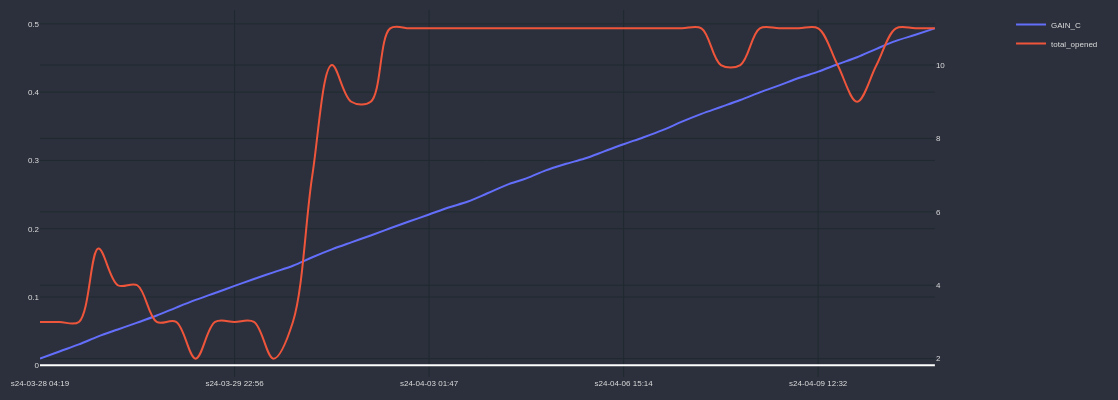

BTCUSDT 68970.0 63327.59 -0.08909876406160418


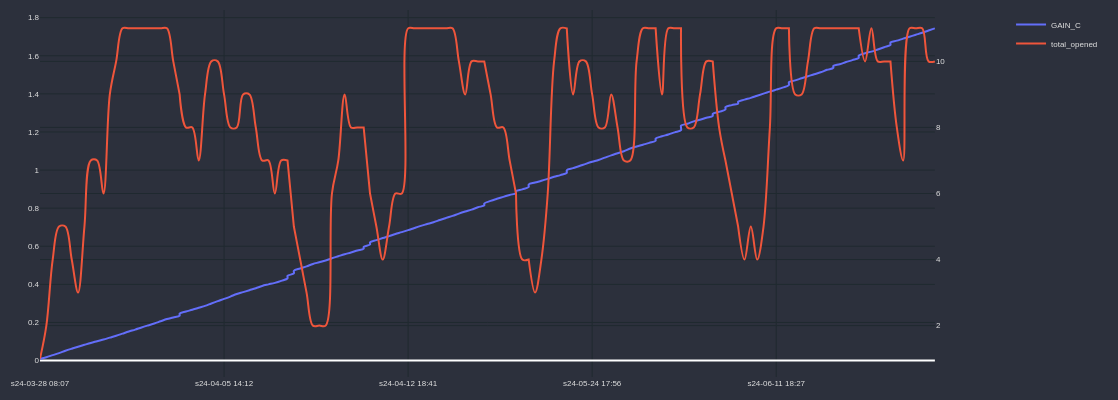

ETHUSDT 3495.52 2602.23 -0.34327864946603487


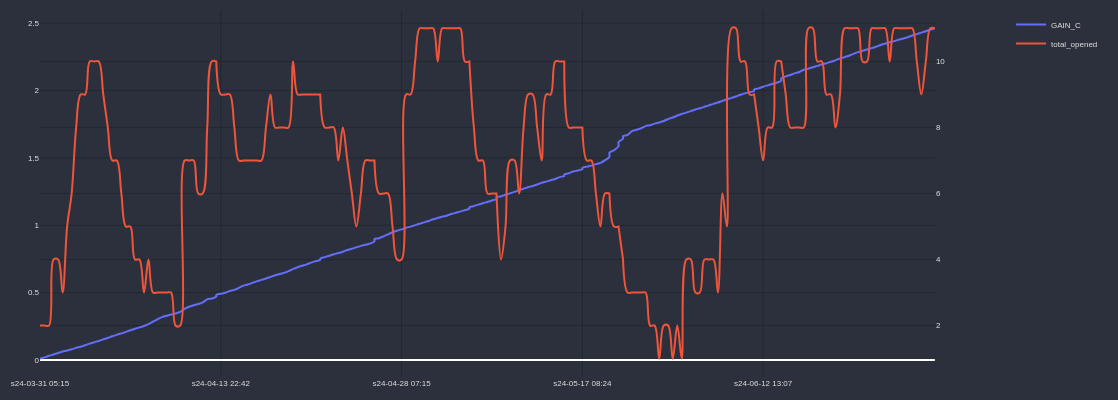

BNBUSDT 572.0 567.4 -0.00810715544589359


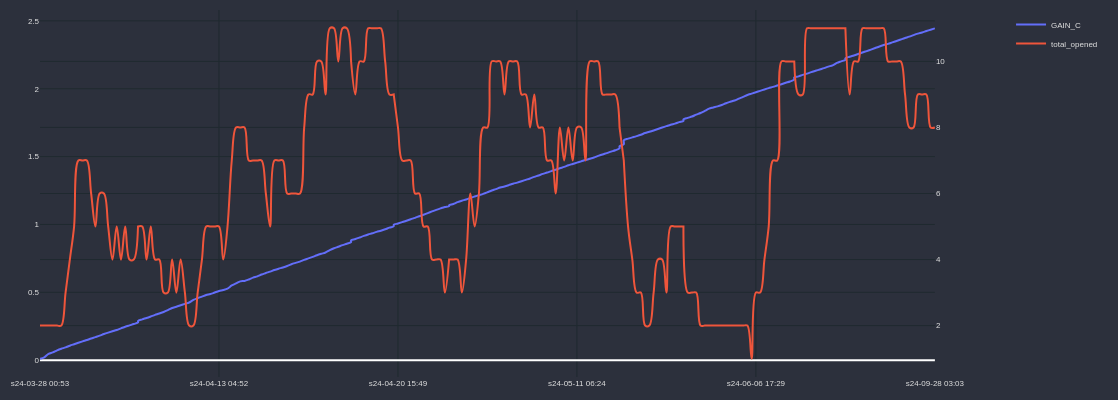

XRPUSDT 0.6213 0.6114 -0.0161923454367025


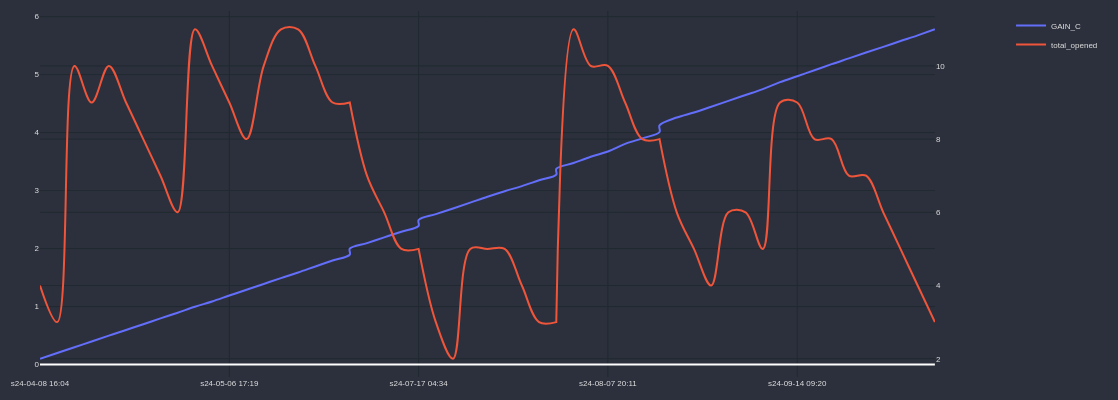

LTCUSDT 95.4 66.82 -0.4277162526189766


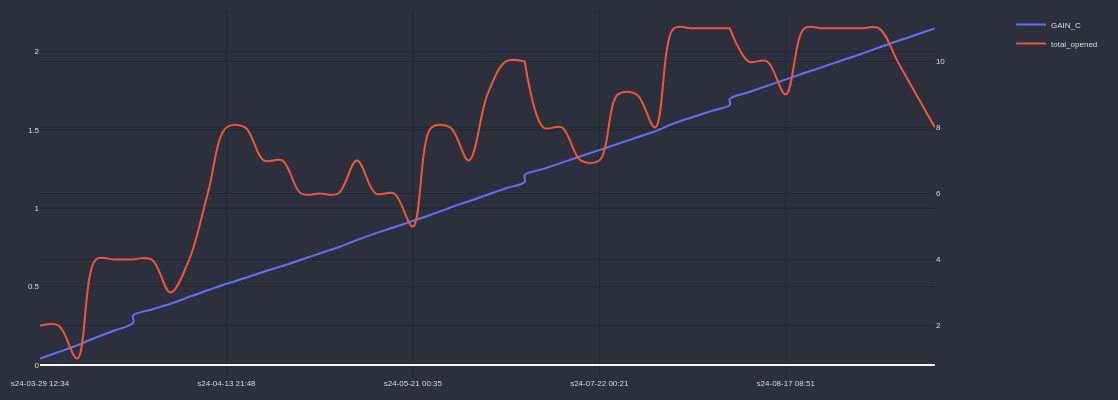

In [48]:
ranks = [rank_ADAUSDT,rank_BTCUSDT, rank_ETHUSDT, rank_BNBUSDT, rank_XRPUSDT, rank_LTCUSDT]

for rank in ranks:
    first_p = rank.iloc[0].first_p
    last_p = rank.iloc[0].last_p
    rel_first_last = (last_p - first_p)/last_p
    print(rank.iloc[0].pair, first_p, last_p, rel_first_last )
    rank.iloc[0].r['time'] = rank.iloc[0].r['end_time']
    rank.iloc[0].r['GAIN_C'] = rank.iloc[0].r.strategy.cumsum()

    cp = CandlePlot(rank.iloc[0].r, candles=False)
    cp.show_plot(line_traces = ['GAIN_C'], sec_traces=['total_opened'])

In [49]:

df_up.describe()

NameError: name 'df_up' is not defined

In [81]:

dd = df_up[df_up['strategy']>0]
# ee = dd[dd['strategy']<0]
# ee

In [82]:
ddf = res[0]['res'].df
test = ddf.iloc[66685:66685+906+1]
test


AttributeError: 'DonchianTrend' object has no attribute 'df'

In [28]:
print(test.iloc[0].Close,test.iloc[-1].Close)
print(test.returns.sum())

3620.8 3618.5
-0.0007575267814862174
